# Time Series Extraction

In [1]:
import xarray as xr
import cf_xarray
import extract_model as em
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import cmocean.cm as cmo

# For this notebook, it's nicer if we don't show the array values by default
xr.set_options(display_expand_data=False)
xr.set_options(display_expand_coords=False)
xr.set_options(display_expand_attrs=False)


## Example model to use

In [2]:
# !wget https://www.ncei.noaa.gov/thredds/fileServer/model-ciofs-files/2022/03/nos.ciofs.fields.n001.20220301.t12z.nc
# !wget https://www.ncei.noaa.gov/thredds/fileServer/model-ciofs-files/2022/03/nos.ciofs.fields.n001.20220301.t18z.nc

In [3]:
# Structured: CIOFS: ROMS Cook Inlet model
# get some model output locally
loc1 = glob('nos.ciofs.*.nc')


# # Unstructured: CREOFS: SELFE Columbia River model
# today = pd.Timestamp.today()
# loc2 = [today.strftime('https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/CREOFS/MODELS/%Y/%m/%d/nos.creofs.fields.n000.%Y%m%d.t03z.nc'),
#         today.strftime('https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/CREOFS/MODELS/%Y/%m/%d/nos.creofs.fields.n001.%Y%m%d.t03z.nc')]


In [4]:
ds1 = xr.open_mfdataset(loc1, preprocess=em.preprocess)
ds1

<xarray.Dataset>
Dimensions:          (ocean_time: 2, tracer: 2, boundary: 4, s_rho: 30,
                      s_w: 31, eta_rho: 1044, xi_rho: 724, eta_u: 1044,
                      xi_u: 723, eta_v: 1043, xi_v: 724, eta_psi: 1043,
                      xi_psi: 723)
Coordinates: (21)
Dimensions without coordinates: tracer, boundary
Data variables: (12/78)
    ntimes           (ocean_time) int32 5400 5400
    ndtfast          (ocean_time) int32 10 10
    dt               (ocean_time) float64 4.0 4.0
    dtfast           (ocean_time) float64 0.4 0.4
    dstart           (ocean_time) datetime64[ns] 2022-03-01T06:00:00 2022-03-...
    nHIS             (ocean_time) int32 900 900
    ...               ...
    w                (ocean_time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 31, 1044, 724), meta=np.ndarray>
    temp             (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 30, 1044, 724), meta=np.ndarray>
    salt             (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 30, 1044, 724), meta=np.ndarray>
    Pair             (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 1044, 724), meta=np.ndarray>
    Uwind            (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 1044, 724), meta=np.ndarray>
    Vwind            (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 1044, 724), meta=np.ndarray>
Attributes: (32)

## Demo code

### Select time series from nearest point

Use a DataArray or a Dataset, but keep in mind that when there are multiple horizontal grids (like there are for ROMS models), you will need to specify which grid's longitude and latitude coordinates to use. The API is meant to be analogous to that of selecting with `xarray` using `.sel()`.

This functionality uses [`xoak`](https://xoak.readthedocs.io/en/latest/).

In [5]:
da1 = ds1['temp']
lon0, lat0 = -151.4, 59  # cook inlet

For any of the following results, access the depth values with

```
[output].cf['vertical'].values
```

#### 2D lon/lat

The first request will take longer than a second request would because the second request uses the index calculated the first time.

In [6]:
%%time
output = da1.em.sel2d(lon_rho=lon0, lat_rho=lat0).squeeze()
output

CPU times: user 659 ms, sys: 24.2 ms, total: 683 ms
Wall time: 680 ms


<xarray.DataArray 'temp' (ocean_time: 2, s_rho: 30)>
dask.array<chunksize=(1, 30), meta=np.ndarray>
Coordinates: (7)
Attributes: (7)

In [7]:
%%time
output = da1.em.sel2d(lon_rho=lon0, lat_rho=lat0).squeeze()
output

CPU times: user 19.1 ms, sys: 2.06 ms, total: 21.2 ms
Wall time: 20.9 ms


<xarray.DataArray 'temp' (ocean_time: 2, s_rho: 30)>
dask.array<chunksize=(1, 30), meta=np.ndarray>
Coordinates: (7)
Attributes: (7)

Access the associated indices:

In [8]:
j, i = int(output.eta_rho.values), int(output.xi_rho.values)

Profile for first time matches:

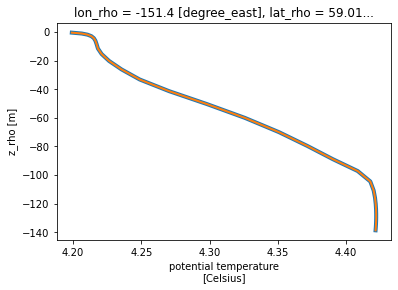

In [9]:
output.cf.isel(T=0).cf.plot(y='vertical', lw=4)
da1.cf.isel(X=i, Y=j, T=0).cf.plot(y='vertical', lw=2)

Surface value for first time matches map:

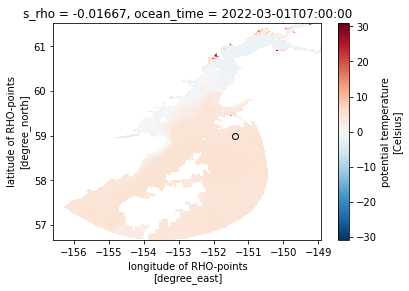

In [10]:
mappable = da1.cf.isel(T=0, Z=-1).cf.plot(x='longitude', y='latitude')
vmin, vmax = mappable.get_clim()
plt.scatter(lon0, lat0, c=output.cf.isel(T=0, Z=-1).values, cmap=mappable.cmap, vmin=vmin, vmax=vmax, edgecolors='k')

To retrieve the values:

`output.values`

In [11]:
output.values

array([[4.4214993, 4.421684 , 4.4218173, 4.421909 , 4.4219575, 4.421951 ,
        4.4218597, 4.4216237, 4.421123 , 4.4200873, 4.4176564, 4.408428 ,
        4.3901873, 4.371695 , 4.350696 , 4.325884 , 4.297998 , 4.270254 ,
        4.248803 , 4.2355056, 4.226392 , 4.2209353, 4.218213 , 4.2172427,
        4.216388 , 4.2152452, 4.213435 , 4.2106075, 4.206378 , 4.199108 ],
       [4.424722 , 4.4244523, 4.4241757, 4.4238887, 4.423582 , 4.4232464,
        4.422875 , 4.4224715, 4.42206  , 4.421729 , 4.421524 , 4.4213953,
        4.421301 , 4.4212065, 4.421026 , 4.4203506, 4.417338 , 4.4085073,
        4.393578 , 4.377725 , 4.365008 , 4.353777 , 4.33955  , 4.3348207,
        4.332366 , 4.3302   , 4.3278446, 4.3250537, 4.321379 , 4.315123 ]],
      dtype=float32)

To retrieve the associated depths:

`output.cf['vertical'].values`

In [12]:
output.cf['vertical'].values

array([[-138.64620096, -136.45404081, -134.29685074, -132.08256877,
        -129.70712397, -127.05153545, -123.98048995, -120.34392005,
        -115.98372281, -110.74806061, -104.51500367,  -97.22473876,
         -88.9147529 ,  -79.74653062,  -70.00912942,  -60.08933079,
         -50.4111136 ,  -41.36259349,  -33.23552631,  -26.19551996,
         -20.28570287,  -15.45354835,  -11.58622257,   -8.54299833,
          -6.17914801,   -4.36054596,   -2.97074644,   -1.91298718,
          -1.10926786,   -0.49803671],
       [-138.64664128, -136.45533117, -134.29897758, -132.08555423,
        -129.71103055, -127.05647178, -123.98661711, -120.35145735,
        -115.99295084, -110.75931885, -104.52867887,  -97.24124086,
         -88.93447733,  -79.76981016,  -70.03618479,  -60.1202327 ,
         -50.44576839,  -41.40075697,  -33.27684118,  -26.2395647 ,
         -20.33203924,  -15.50175845,  -11.63593229,   -8.5938881 ,
          -6.2309544 ,   -4.41305754,   -3.02379693,   -1.96644783,
         

#### 3D lon/lat/Z or iZ

Return model output nearest to lon, lat, Z value. `z_rho` has two values because the depth changes in time.

In [13]:
out = da1.em.sel2d(lon_rho=lon0, lat_rho=lat0).squeeze()
out

<xarray.DataArray 'temp' (ocean_time: 2, s_rho: 30)>
dask.array<chunksize=(1, 30), meta=np.ndarray>
Coordinates: (7)
Attributes: (7)

In [14]:
out.em.selZ(depths=-40)

<xarray.DataArray 'temp' (ocean_time: 2)>
dask.array<chunksize=(1,), meta=np.ndarray>
Coordinates: (7)
Attributes: (7)

Return model output nearest to lon, lat, at index iZ in Z dimension.

In [15]:
da1.em.sel2d(lon_rho=lon0, lat_rho=lat0).cf.isel(Z=-1)

<xarray.DataArray 'temp' (ocean_time: 2, loc: 1)>
dask.array<chunksize=(1, 1), meta=np.ndarray>
Coordinates: (7)
Dimensions without coordinates: loc
Attributes: (7)

### Interpolate time series at exact point

In [16]:
da1 = ds1['salt']
lon0, lat0 = -152, 58
lons, lats = [-151, -152], [59,58]

#### 2D lon/lat

1 lon/lat pair

In [17]:
%%time
output = da1.em.interp2d(lon0, lat0)
output

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


CPU times: user 17 s, sys: 448 ms, total: 17.5 s
Wall time: 17.6 s


<xarray.DataArray 'salt' (ocean_time: 2, s_rho: 30)>
dask.array<chunksize=(1, 30), meta=np.ndarray>
Coordinates: (5)
Attributes: (7)

Surface value for first time matches map:

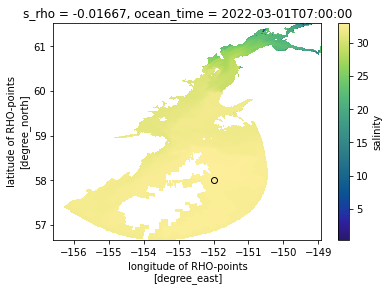

In [18]:
cmap=cmo.haline
mappable = da1.cf.isel(T=0, Z=-1).cf.plot(x='longitude', y='latitude', cmap=cmap)
vmin, vmax = mappable.get_clim()
plt.scatter(lon0, lat0, c=output.cf.isel(T=0, Z=-1).values, cmap=cmap, vmin=vmin, vmax=vmax, edgecolors='k')

To retrieve the values:

`output.values`

In [19]:
output.values

array([[32.93971 , 32.939648, 32.939594, 32.93954 , 32.939472, 32.939392,
        32.939293, 32.93917 , 32.93898 , 32.93863 , 32.937885, 32.936424,
        32.933247, 32.92608 , 32.918026, 32.910328, 32.903812, 32.898037,
        32.892227, 32.88485 , 32.877373, 32.875435, 32.875843, 32.87596 ,
        32.875977, 32.875988, 32.875996, 32.875996, 32.87599 , 32.875977],
       [32.935272, 32.935257, 32.93523 , 32.9352  , 32.93515 , 32.93508 ,
        32.934994, 32.934853, 32.934593, 32.934105, 32.93326 , 32.931606,
        32.92794 , 32.921555, 32.913635, 32.905594, 32.898544, 32.892017,
        32.88495 , 32.876884, 32.87071 , 32.868958, 32.86884 , 32.86886 ,
        32.86887 , 32.868885, 32.868904, 32.86892 , 32.868946, 32.86898 ]],
      dtype=float32)

To retrieve the associated depths:

`output.cf['vertical'].values`

In [20]:
output.cf['vertical'].values

array([[-170.93673211, -168.23867249, -165.58365323, -162.85836659,
        -159.9347245 , -156.66628805, -152.88651681, -148.41071134,
        -143.0442822 , -136.60035119, -128.92884998, -119.95616184,
        -109.72842493,  -98.44439063,  -86.45982418,  -74.25076722,
         -62.33904308,  -51.20233542,  -41.19973055,  -32.53505482,
         -25.26138969,  -19.31408652,  -14.55427209,  -10.80874262,
          -7.89937074,   -5.66107772,   -3.95054486,   -2.64867942,
          -1.65948041,   -0.90719136],
       [-170.93469594, -168.23270543, -165.573818  , -162.84456081,
        -159.91665917, -156.64346084, -152.85818274, -148.37585633,
        -143.00160868, -136.54828932, -128.86561127, -119.87985055,
        -109.63721254,  -98.33673819,  -86.33471107,  -74.10786637,
         -62.17878768,  -51.02585461,  -41.00867665,  -32.33137709,
         -25.04711474,  -19.09114677,  -14.32439762,  -10.57341118,
          -7.65980055,   -5.4182465 ,   -3.7052215 ,   -2.40145934,
         

multiple lon/lat pairs

In [21]:
%%time
da1.em.interp2d(lons, lats)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


CPU times: user 15.2 s, sys: 373 ms, total: 15.6 s
Wall time: 15.7 s


<xarray.DataArray 'salt' (ocean_time: 2, s_rho: 30, lat: 2, lon: 2)>
dask.array<chunksize=(1, 30, 2, 2), meta=np.ndarray>
Coordinates: (5)
Attributes: (7)

#### 3D: lon, lat, iZ

Return model output interpolated to lon, lat, Z value.

In [22]:
da1.em.interp2d(lon0, lat0, Z=-40)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


<xarray.DataArray 'salt' (ocean_time: 2)>
dask.array<chunksize=(1,), meta=np.ndarray>
Coordinates: (5)
Attributes: (7)

Return model output interpolated to lon, lat, at index iZ in Z dimension.

In [23]:
da1.em.interp2d(lon0, lat0, iZ=-1)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


<xarray.DataArray 'salt' (ocean_time: 2)>
dask.array<chunksize=(1,), meta=np.ndarray>
Coordinates: (5)
Attributes: (7)

Note that it is not currently possible to interpolate in depth when there are both multiple times and locations.

If uncommented, the following cell will return:
> NotImplementedError: Currently it is not possible to interpolate in depth with more than 1 other (time) dimension.

In [24]:
# da1.em.interp2d(lons, lats, Z=-40)